# 训练和数学 - 前向/反向/梯度/优化 

> 优化  这个词不要联想到程序优化这样的场景 ---- 在机器学习领域是指更新“参数”的值 这个工作


1. 前向传播: 输入数据通过网络,计算预测输出。

2. 计算损失: 比较预测输出和实际标签,得到误差。

3. 反向传播: 误差从输出层向输入层反向传播,计算每个权重对误差的贡献(梯度)。

4. 更新权重: 使用优化算法(如梯度下降)根据计算出的梯度更新所有权重。

这个过程对每一行数据(在批量处理中是每一批数据)都会重复进行。因此:

- 在随机梯度下降(SGD)中,每处理一行数据就更新一次所有权重。
- 在小批量梯度下降中,每处理一个批次的数据就更新一次所有权重。
- 在批量梯度下降中,处理完所有数据后更新一次所有权重。

这种频繁的更新允许模型逐步学习数据中的模式,不断调整以最小化预测误差。

需要注意的是,虽然每次都更新所有权重,但每个权重的更新幅度可能不同,这取决于该权重对当前误差的贡献程度。

In [10]:
# 神经网络的极简例子
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
# 防止画plt报错的一个处理办法

In [12]:

# 设置随机种子以确保结果可复现
torch.manual_seed(42)

# 创建模拟数据
# 10条数据，每条4个特征
X = torch.randn(100, 4)
# 创建目标值（这里我们假设是回归问题，每个样本对应一个目标值）
y = torch.randn(100, 1)

# 定义神经网络模型
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(4, 8)  # 输入层到隐藏层 这里4个输入， 对应我们在数据准备X的4个特征
        self.fc2 = nn.Linear(8, 1)  # 隐藏层到输出层
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 实例化模型、损失函数和优化器
model = SimpleNet()



## 探索参数

每一层都包含 权重  weight 和 偏执 bias 

1. 第一层 (fc1): nn.Linear(4, 8)
   - 权重矩阵: 4 * 8 = 32 个参数
   - 偏置项: 8 个参数
   - 小计: 32 + 8 = 40 个参数

2. 第二层 (fc2): nn.Linear(8, 1)
   - 权重矩阵: 8 * 1 = 8 个参数
   - 偏置项: 1 个参数
   - 小计: 8 + 1 = 9 个参数

3. ReLU 激活函数
   - ReLU 不含有可训练参数

总参数数量: 40 + 9 = 49 个参数

我们可以通过 PyTorch 提供的方法来验证这一点：

```python
model = SimpleNet()
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
```

这应该输出：
```
Total number of parameters: 49
```

如果你想查看更详细的参数分布，可以使用：

```python
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()}")
```

这会显示每一层的参数数量和大小。

记住，在神经网络中：
- 每个全连接层（Linear层）的参数数量 = 输入特征数 * 输出特征数 + 输出特征数（偏置项）
- 激活函数如ReLU通常不包含可训练参数

这个模型虽然看起来简单，但已经有49个可训练参数，这展示了即使是小型神经网络也可能包含相当数量的参数。

In [16]:
def probeParam():
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params}")
    for name, param in model.named_parameters():
        print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()} | {param}")
    #grad
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"  {name} gradient: {param.grad}")


In [18]:
 probeParam()

Total number of parameters: 49
Layer: fc1.weight | Size: torch.Size([8, 4]) | Parameters: 32 | Parameter containing:
tensor([[ 0.4357, -0.4735,  0.3772, -0.0168],
        [-0.0581,  0.3127, -0.0462,  0.3136],
        [ 0.3615, -0.4341,  0.1924,  0.0944],
        [ 0.1075,  0.0730,  0.1368, -0.2405],
        [-0.0640,  0.4751,  0.3359, -0.0188],
        [-0.4703,  0.0219, -0.3405,  0.4066],
        [-0.3035, -0.0361, -0.1110,  0.0890],
        [ 0.4705,  0.0475,  0.2896,  0.3881]], requires_grad=True)
Layer: fc1.bias | Size: torch.Size([8]) | Parameters: 8 | Parameter containing:
tensor([ 0.4037, -0.1727, -0.1118,  0.2410, -0.1364,  0.2341, -0.1092, -0.3391],
       requires_grad=True)
Layer: fc2.weight | Size: torch.Size([1, 8]) | Parameters: 8 | Parameter containing:
tensor([[ 0.1439,  0.0542,  0.1576,  0.3513,  0.2414,  0.3352,  0.0189, -0.3041]],
       requires_grad=True)
Layer: fc2.bias | Size: torch.Size([1]) | Parameters: 1 | Parameter containing:
tensor([-0.2480], requires_grad

In [20]:
criterion = nn.MSELoss() #定义损失函数
optimizer = optim.SGD(model.parameters(), lr=0.01) # 定义优化器和学习率

## 训练 raining 

一个epoch内包含

1 一次前向传播  forward (所有参数的初始化可以随机)

2 拿到1的结果值， 计算误差和损失 - 按照指定的损失函数

3 根据损失函数 反向传播backward 计算每个参数对于结果的影响的 ”梯度“

4 调用优化器， 根据backward过程中计算出来的每个参数的梯度反向更新参数

整个过程称为一个收敛的过程

> 学习率的不当设定可能会导致无法收敛

CPU times: total: 0 ns
Wall time: 0 ns
Epoch [100/1000], Loss: 0.8403
Epoch [200/1000], Loss: 0.8291
Epoch [300/1000], Loss: 0.8194
Epoch [400/1000], Loss: 0.8113
Epoch [500/1000], Loss: 0.8038
Epoch [600/1000], Loss: 0.7966
Epoch [700/1000], Loss: 0.7909
Epoch [800/1000], Loss: 0.7861
Epoch [900/1000], Loss: 0.7812
Epoch [1000/1000], Loss: 0.7764


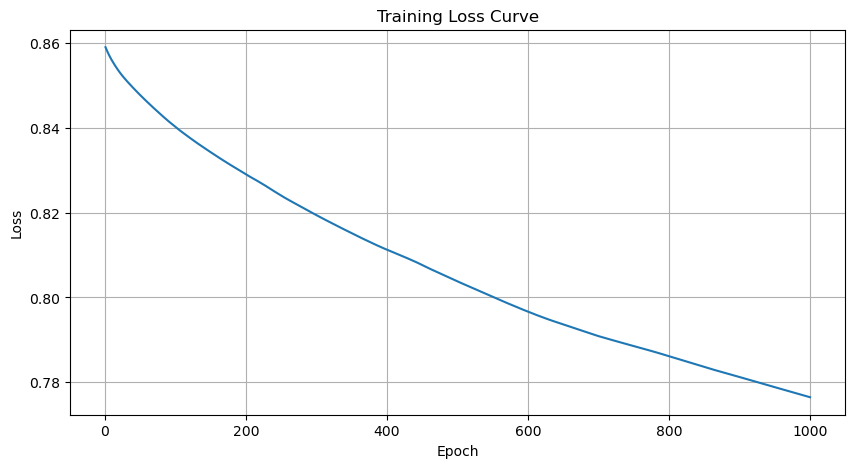

In [22]:
%%time
%matplotlib inline


# 训练模型
num_epochs = 1000
losses = []  # 用于存储每个epoch的损失

#print(X)
for epoch in range(num_epochs):
    # 前向传播
   
    outputs = model(X) # 前向传播 - 计算最后的输出值
    loss = criterion(outputs, y) # 根据损失计算函数去计算当前损失
    # 反向传播和优化
    optimizer.zero_grad() # 重置梯度
    loss.backward(retain_graph=True) # 反向传播 - 反向传播会计算每个权重的偏导数（权重对于结果的影响） - 复合函数-偏导数-链式法则 等数据原来都是应用在这里 - 确保权重更新的方向是偏向于loss变小的方向
    optimizer.step() # 这里才是更新权重值
    # probeParam()
    # 记录损失
    losses.append(loss.item())
    
    # 打印每100个epoch的损失
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


```
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036],
        ...,
        [-0.7324, -0.5639,  0.0400, -0.4779],
        [-0.4352,  0.5881, -1.1905,  0.3114],
        [-0.5756,  0.3273,  0.6297,  1.8795]])
Epoch [100/1000], Loss: 1.1081
Epoch [200/1000], Loss: 1.1081
Epoch [300/1000], Loss: 1.1081
Epoch [400/1000], Loss: 1.1081
Epoch [500/1000], Loss: 1.1081
Epoch [600/1000], Loss: 1.1081
Epoch [700/1000], Loss: 1.1081
Epoch [800/1000], Loss: 1.1081
Epoch [900/1000], Loss: 1.1081
Epoch [1000/1000```

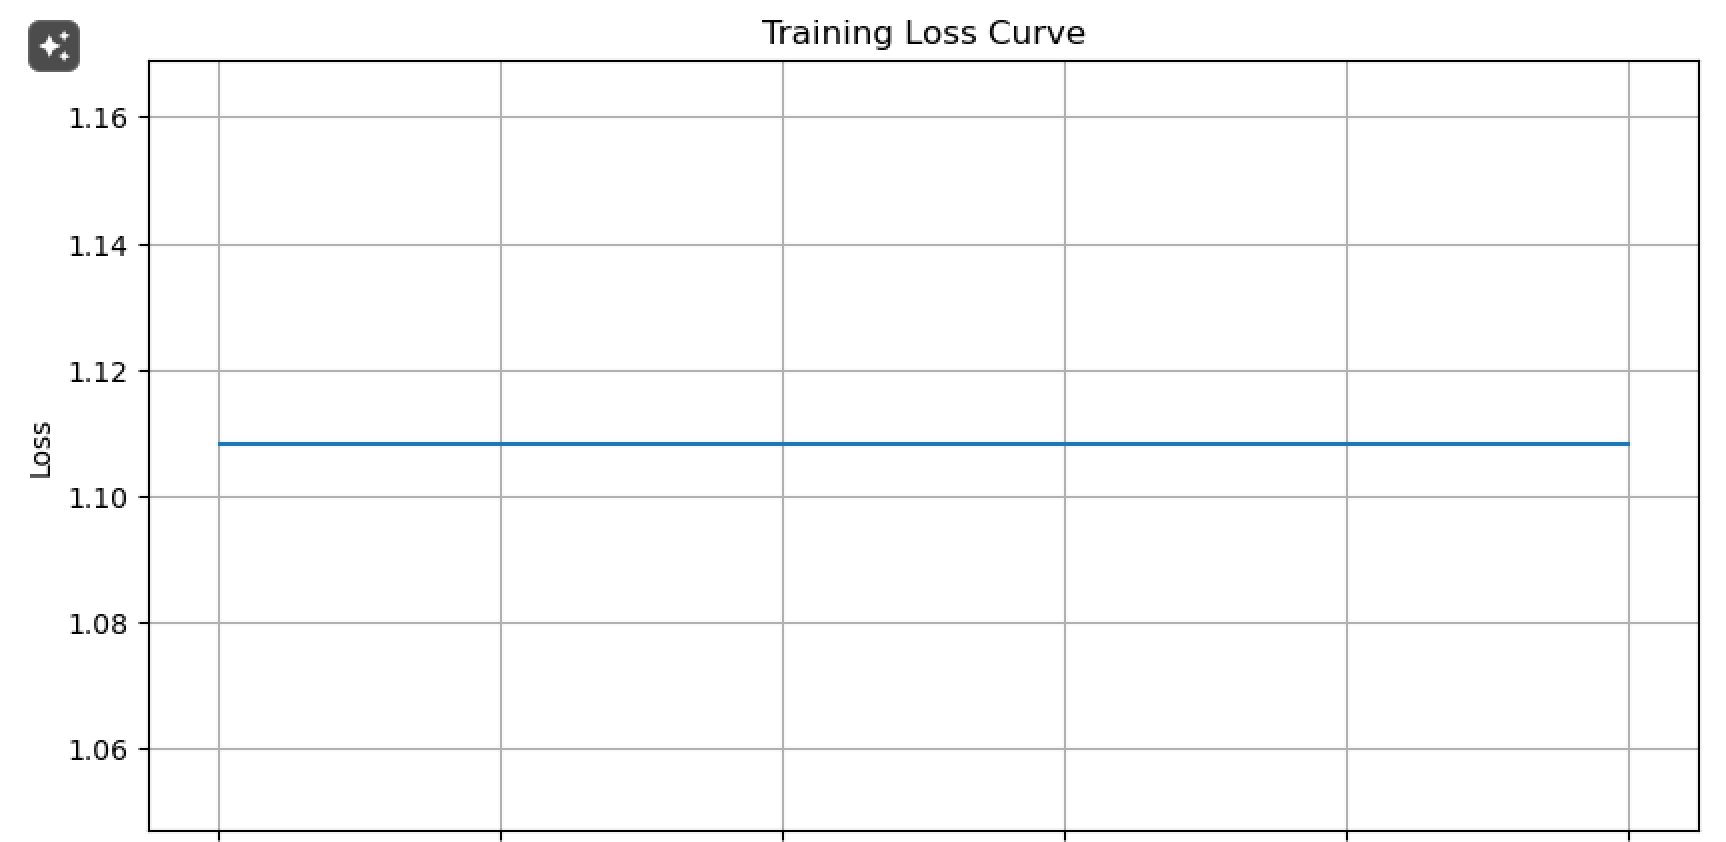], Loss: 1.1081


## 测试模型



1. 切换模型到评估模式：
   - `model.eval()` 将模型切换到评估模式。

2. 影响特定层的行为：
   - 主要影响如 Dropout 和 BatchNorm 这样的层。
   - 在训练模式下，Dropout 层会随机丢弃一些神经元，而在评估模式下不会。
   - BatchNorm 层在训练模式下会更新其运行平均值和方差，而在评估模式下使用固定的统计数据。

3. 禁用梯度计算：
   - 虽然 `model.eval()` 本身不会禁用梯度计算，但它通常与 `torch.no_grad()` 一起使用。

4. 确保一致性：
   - 在评估或推理时使用 `model.eval()` 确保模型的输出是一致的。

5. 不影响权重：
   - `model.eval()` 不会改变模型的权重。

6. 可逆操作：
   - 可以使用 `model.train()` 将模型切回训练模式。

在您的代码中：

```python
model.eval()
with torch.no_grad():
    test_output = model(X)
    print("预测值:")
    print(test_output)
    print("实际值:")
    print(y)
    print("差值:")
    print(test_output - y)
```

这里 `model.eval()` 确保模型在进行预测时处于评估模式。`with torch.no_grad():` 则进一步禁用了梯度计算，这在推理时可以提高效率并节省内存。

总的来说，`model.eval()` 是在进行模型评估或推理时的一个重要步骤，它确保模型的行为与训练时一致，并优化了推理过程。

In [26]:
model.eval()
with torch.no_grad():
    test_output = model(X)
    print("预测值:")
    print(test_output)
    print("实际值:")
    print(y)
    print("差值:")
    print(test_output - y)

预测值:
tensor([[-0.0048],
        [ 0.2465],
        [ 0.2105],
        [ 0.0931],
        [-0.1833],
        [ 0.0375],
        [-0.2563],
        [-0.1536],
        [ 0.1915],
        [-0.0738],
        [ 0.3796],
        [ 0.6404],
        [-0.0622],
        [ 0.1459],
        [-0.0013],
        [ 0.3863],
        [ 0.2549],
        [-0.0183],
        [-0.1906],
        [ 0.1831],
        [ 0.0413],
        [-0.0569],
        [ 0.0217],
        [-0.2095],
        [ 0.1095],
        [-0.0645],
        [-0.2114],
        [-0.1185],
        [ 0.1864],
        [-0.2702],
        [-0.2036],
        [-0.0754],
        [-0.3552],
        [-0.0357],
        [-0.0060],
        [ 0.1102],
        [-0.0404],
        [-0.1043],
        [-0.0733],
        [ 0.6190],
        [ 0.1095],
        [ 0.0025],
        [ 0.0493],
        [ 0.1683],
        [-0.1057],
        [ 0.2612],
        [ 0.3934],
        [ 0.0866],
        [ 0.3053],
        [-0.0419],
        [ 0.1222],
        [-0.0965],
       